In [1]:
!git clone https://github.com/neuroailab/lr-identify
%cd lr-identify

Cloning into 'lr-identify'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 44 (delta 8), reused 34 (delta 4), pack-reused 0
Unpacking objects: 100% (44/44), done.
/content/lr-identify


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
!bash get_dataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  511M  100  511M    0     0  25.3M      0  0:00:20  0:00:20 --:--:-- 23.1M


In [4]:
data = pickle.load(open('dataset.pkl', 'rb'), encoding='latin1')

In [5]:
learning_rules = ['information', 'feedback']
task_filter = ['imagenet', 'simclr']
batch_filter = [256]
architecture_filter = ['resnet18']
cls_filter = lambda x: (x['learning_rule'] in learning_rules) and (x['task'] in task_filter) and (x['batch_size'] in batch_filter) and (x['architecture'] in architecture_filter)

In [6]:
from cross_validation import get_possible_inds

cls_filter_first_lr = lambda x: (x['learning_rule'] == learning_rules[0]) and (x['task'] in task_filter) and (x['batch_size'] in batch_filter) and (x['architecture'] in architecture_filter)
cls_filter_first_lr_indices = get_possible_inds(data['meta'], cls_filter_first_lr)
num_total_per_class = len(cls_filter_first_lr_indices)
num_total_examples =  num_total_per_class * len(learning_rules)
# sanity check for category balanced data
assert(num_total_examples == len(get_possible_inds(data['meta'], cls_filter)))
# now we compute num per class train and test
train_frac = 0.75
num_per_class_train = (int)(np.ceil(train_frac*num_total_per_class))
num_per_class_test = (int)(num_total_per_class - num_per_class_train)
print(num_total_examples)

360


In [7]:
from fit_pipeline import PipelineClassifier
from functools import partial

classifier_type = partial(PipelineClassifier, estimators=[('cls', 'randomforest')])
cv_param_grid = {'cls__max_features': ['sqrt', 'log2'], 'cls__n_estimators': [20, 50]}

In [ ]:
import copy
from fit_pipeline import ObsClassifier
noise = [0,0.5,1,5,10]
metrics = ['weight', 'act', 'grad']
test_accuracy = np.zeros((5,3))
for i in range(len(noise)):
  data1 = copy.deepcopy(data)
  data1['X'] += np.sqrt(noise[i])*np.random.randn(20736,21,45)
  for j in range(len(metrics)):

    

    cls_out = ObsClassifier(
                  classifier_type=classifier_type, # 'randomforest' in this case
                  num_splits=10, # number of train/test splits
                  num_per_class_train=num_per_class_train, # how many examples per category to train on
                  num_per_class_test=num_per_class_test, # how many examples per category to test on
                  train_filter=cls_filter, # the subset of data we want to train on
                  test_filter=cls_filter, # the subset of data we want to test on
                  data=data1, # the raw data
                  cls_dataset_transform_kwargs={'obs_measure': metrics[j], 'num_dims': 2}, # train on activations observable measure, flattening trajectories
                  cv_param_grid=cv_param_grid, # cross validation search space
                  verbose=True)
    test_accuracy[i][j] = cls_out.results['test']['mean_accuracy']



Will be running cross val and returning results.
Score: 0.9259259259259259. Num train examples: 216. Num val examples: 54
Score: 0.9259259259259259. Num train examples: 216. Num val examples: 54
Score: 0.9629629629629629. Num train examples: 216. Num val examples: 54
Score: 0.9074074074074074. Num train examples: 216. Num val examples: 54
Score: 0.9814814814814815. Num train examples: 216. Num val examples: 54
Score: 0.9444444444444444. Num train examples: 216. Num val examples: 54
Score: 0.9259259259259259. Num train examples: 216. Num val examples: 54
Score: 0.9444444444444444. Num train examples: 216. Num val examples: 54
Score: 0.9259259259259259. Num train examples: 216. Num val examples: 54
Score: 1.0. Num train examples: 216. Num val examples: 54
Score: 0.9074074074074074. Num train examples: 216. Num val examples: 54
Score: 0.9814814814814815. Num train examples: 216. Num val examples: 54
Score: 0.9444444444444444. Num train examples: 216. Num val examples: 54
Score: 0.94444444

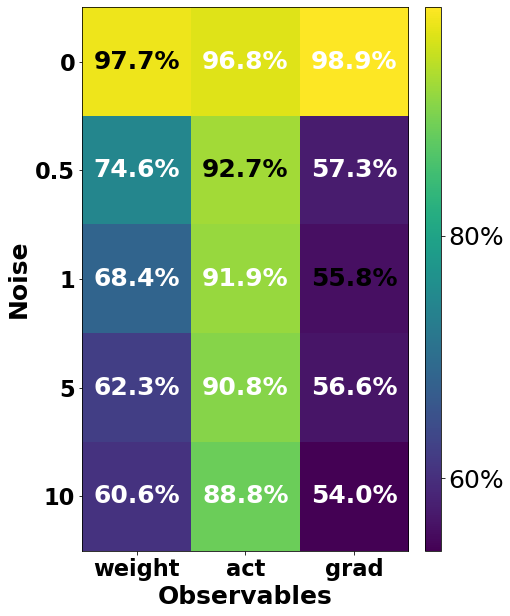

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12.5, 10))
ax = plt.subplot(1, 1, 1)
im = ax.imshow(test_accuracy, cmap=plt.get_cmap('viridis'))
# label ticks with class labels
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(['weight','act','grad'], 
                   fontsize=22.5, fontweight='bold')
ax.set_yticklabels([0,0.5,1,5,10], 
                   fontsize=22.5, fontweight='bold')
# x and y labels
ax.set_xlabel('Observables', fontsize=25, fontweight='bold')
ax.set_ylabel('Noise', fontsize=25, fontweight='bold')
# loop over data dimensions and create text annotations
for i in range(test_accuracy.shape[0]):
    for j in range(test_accuracy.shape[1]):
        text = ax.text(j, i, "{:.1f}%".format(test_accuracy[i, j]*100),
                       ha="center", va="center", 
                       color="w" if i != j else "k",
                       fontsize=25, fontweight='bold')
        
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax,
                    width="5%",  # width = 5% of parent_bbox width
                    height="100%",  # height : 50%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
                    )
cbar = fig.colorbar(im, cax=axins, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
cbar.ax.tick_params(labelsize=25)
plt.show()